# Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/ANDL/Homework_2

/gdrive/MyDrive/ANDL/Homework_2


# Libraries

In [3]:
!pip install keras_self_attention

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18913 sha256=c89969640b8bbe9d66a846b9a87dac67634e9ade631fcf689ba7443577010e4b
  Stored in directory: /root/.cache/pip/wheels/ac/13/2d/3de7c76f618a8d162884ac5b726a8c2242ad88afa370f1e62f
Successfully built keras-self-attention


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention
from tensorflow.keras import regularizers

import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Load Data

In [6]:
X_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [7]:
df = pd.DataFrame()

for t in range(0, 2429):
  temp_df = pd.DataFrame(X_train[t, :, :])
  temp_df["serie"] = t
  temp_df["target"] = y_train[t]
  df = pd.concat([df, temp_df])
df = df.rename(columns={0:"x0", 1:"x1", 2:"x2", 3:"x3", 4:"x4", 5:"x5"})
print(df)

          x0        x1        x2        x3        x4       x5  serie  target
0   17.59700   8.17130  -1.78420 -19.70600  -9.71350 -61.8870      0       0
1    0.22974  -5.89560  16.83700   5.03900   2.43320  58.9140      0       0
2  -29.65400 -21.29600  29.10300  -0.47503  75.39100  10.6650      0       0
3  -59.21000 -29.56500  17.97100 -45.60600  19.41200 -43.0140      0       0
4  -72.06400 -25.85500   0.46536 -59.15100 -29.10500 -11.9130      0       0
..       ...       ...       ...       ...       ...      ...    ...     ...
31   3.51190  -1.03240  -1.69900   4.15790   2.75430   5.9823   2428      11
32   0.70853  -0.94622  -1.91760   2.09480  -4.76750   7.4118   2428      11
33   0.20638   1.02870  -0.92512  -0.71633   1.73330   4.7638   2428      11
34   4.14290   1.09390  -0.18921   1.14100   0.93441   4.1742   2428      11
35  -1.55450  -1.21210   1.07050   1.32720   2.40100   8.4550   2428      11

[87444 rows x 8 columns]


In [8]:
df.head(1000)

,x0,x1,x2,x3,x4,x5,serie,target
0,17.59700,8.1713,-1.784200,-19.70600,-9.7135,-61.887,0,0
1,0.22974,-5.8956,16.837000,5.03900,2.4332,58.914,0,0
2,-29.65400,-21.2960,29.103000,-0.47503,75.3910,10.665,0,0
3,-59.21000,-29.5650,17.971000,-45.60600,19.4120,-43.014,0,0
4,-72.06400,-25.8550,0.465360,-59.15100,-29.1050,-11.913,0,0
...,...,...,...,...,...,...,...,...
23,-4.56440,4.7574,1.666500,30.24900,3.5516,72.818,27,0
24,2.68540,9.7023,6.918400,-19.56100,-50.0060,-22.576,27,0
25,11.47700,8.9163,20.230000,-3.72380,66.5000,47.156,27,0
26,15.94500,3.9105,14.408000,25.17500,8.3458,87.464,27,0


In [9]:
# Add a date to use the seasonal_decompose module which requires a date for the points
df['date'] = pd.date_range(start='1/1/1900', periods=len(df))
# Convert daily column from just string to DateTime
df['date'] = pd.to_datetime(df['date'])
# Set the column 'Date' as index 
df = df.set_index('date')
# Specify datetime frequency
df = df.asfreq('D')
print(df.shape)
df.head()

(87444, 8)


,x0,x1,x2,x3,x4,x5,serie,target
date,,,,,,,,
1900-01-01,17.59700,8.1713,-1.78420,-19.70600,-9.7135,-61.887,0,0
1900-01-02,0.22974,-5.8956,16.83700,5.03900,2.4332,58.914,0,0
1900-01-03,-29.65400,-21.2960,29.10300,-0.47503,75.3910,10.665,0,0
1900-01-04,-59.21000,-29.5650,17.97100,-45.60600,19.4120,-43.014,0,0
1900-01-05,-72.06400,-25.8550,0.46536,-59.15100,-29.1050,-11.913,0,0


In [10]:
y_df_train = pd.DataFrame()
y_df_train['target'] = df['target'].values
y_df_train['serie'] = df['serie'].values
print(y_df_train)

       target  serie
0           0      0
1           0      0
2           0      0
3           0      0
4           0      0
...       ...    ...
87439      11   2428
87440      11   2428
87441      11   2428
87442      11   2428
87443      11   2428

[87444 rows x 2 columns]


In [11]:
df = df.rolling(3).mean()

In [12]:
df['target'] = y_df_train['target'].values
df['serie'] = y_df_train['serie'].values

In [13]:
df= df.fillna(0)

In [14]:
df.head(100)

,x0,x1,x2,x3,x4,x5,serie,target
date,,,,,,,,
1900-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0
1900-01-03,-3.942420,-6.340100,14.718600,-5.047343,22.703567,2.564000,0,0
1900-01-04,-29.544753,-18.918867,21.303667,-13.680677,32.412067,8.855000,0,0
1900-01-05,-53.642667,-25.572000,15.846453,-35.077343,21.899333,-14.754000,0,0
...,...,...,...,...,...,...,...,...
1900-04-06,23.175667,-41.488333,-0.244790,-2.244867,-34.383000,7.767200,2,0
1900-04-07,18.440667,-20.883633,1.193043,1.824517,-20.092800,12.596133,2,0
1900-04-08,3.044000,-0.264967,5.621777,-1.006183,-9.958800,3.792333,2,0


In [15]:
window = 36
stride = 36

In [16]:
def build_sequences(df, window=36, stride=36):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    for s in df['serie'].unique():
        # Take only meaningful features
        temp = df[df['serie'] == s][['x0', 'x1', 'x2', 'x3', 'x4', 'x5']].values
        # Save the label
        label = df[df['serie'] == s]['target'].values[0]
        # Compute padding length
        #padding_len = window - len(temp)%window
        # Create padding and concatenate it
        #padding = np.zeros((padding_len,6), dtype='float64')
        #temp = np.concatenate((temp,padding))
        # Build features windows with their corresponging labels
        idx = 0
        while idx+window <= len(temp):
            dataset.append(temp[idx:idx+window])
            labels.append(label)
            idx += stride
    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [17]:
X_train, y_train = build_sequences(df, window, stride)
X_train.shape, y_train.shape

((2429, 36, 6), (2429,))

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train ,random_state=104, test_size=0.15, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064,), (365, 36, 6), (365,))

In [19]:
# Convert the sparse labels to categorical values
y_train = tfk.utils.to_categorical(y_train)
y_test = tfk.utils.to_categorical(y_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2064, 36, 6), (2064, 12), (365, 36, 6), (365, 12))

In [20]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 32
epochs = 200

In [75]:
def build_BiLSTM_classifier(input_shape, classes):
    n_feature_maps = 64

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Feature extractor
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, kernel_regularizer=regularizers.L2(0.01), return_sequences=True))(input_layer)
    bilstm = tfkl.Dropout(.5, seed=seed)(bilstm)
    bilstm = tfkl.Bidirectional(tfkl.LSTM(128, kernel_regularizer=regularizers.L2(0.01), return_sequences=True))(bilstm)
    bilstm = tfkl.Dropout(.5, seed=seed)(bilstm)

    attention = SeqSelfAttention(attention_activation='sigmoid')(bilstm)

    lstm = tfkl.GlobalAveragePooling1D()(attention)

    dropout = tfkl.Dropout(.5, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(128, activation='relu')(dropout)
    output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [76]:
model = build_BiLSTM_classifier(input_shape, classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 36, 6)]           0         
                                                                 
 bidirectional_12 (Bidirecti  (None, 36, 256)          138240    
 onal)                                                           
                                                                 
 dropout_19 (Dropout)        (None, 36, 256)           0         
                                                                 
 bidirectional_13 (Bidirecti  (None, 36, 256)          394240    
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 36, 256)           0         
                                                                 
 seq_self_attention_5 (SeqSe  (None, 36, 256)          16449 

In [67]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    #class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
59/59 [==============================] - 14s 114ms/step - loss: 2.0615 - accuracy: 0.3565 - val_loss: 2.2122 - val_accuracy: 0.2609 - lr: 0.0010
Epoch 2/200
59/59 [==============================] - 6s 99ms/step - loss: 1.8669 - accuracy: 0.3931 - val_loss: 2.3136 - val_accuracy: 0.2705 - lr: 0.0010
Epoch 3/200
59/59 [==============================] - 6s 97ms/step - loss: 1.8046 - accuracy: 0.4066 - val_loss: 2.5222 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/200
59/59 [==============================] - 6s 99ms/step - loss: 1.7628 - accuracy: 0.4012 - val_loss: 2.3615 - val_accuracy: 0.3043 - lr: 0.0010
Epoch 5/200
59/59 [==============================] - 6s 99ms/step - loss: 1.7263 - accuracy: 0.4103 - val_loss: 2.7568 - val_accuracy: 0.1159 - lr: 0.0010
Epoch 6/200
59/59 [==============================] - 7s 113ms/step - loss: 1.6801 - accuracy: 0.4168 - val_loss: 2.2140 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 7/200
59/59 [==============================] - 7s 112ms/step 

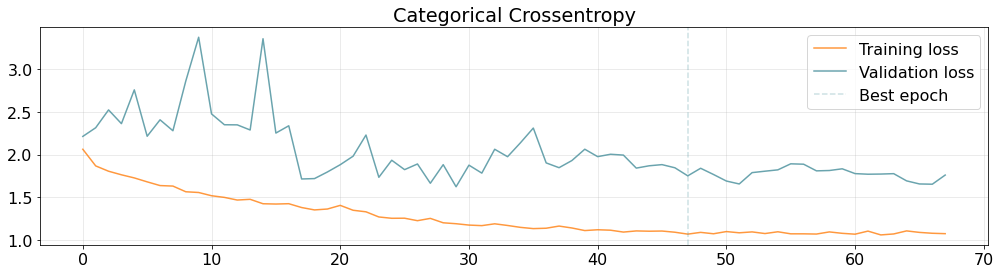

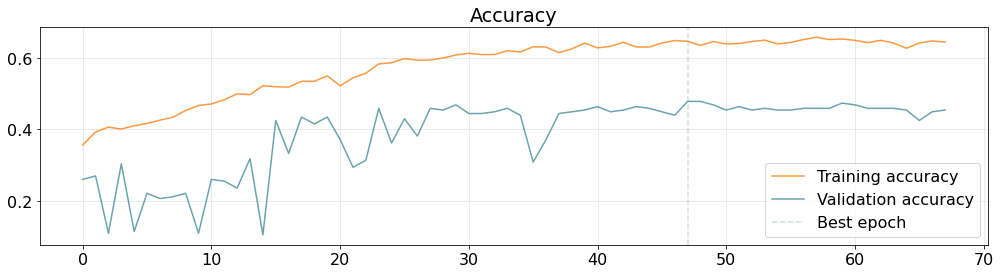

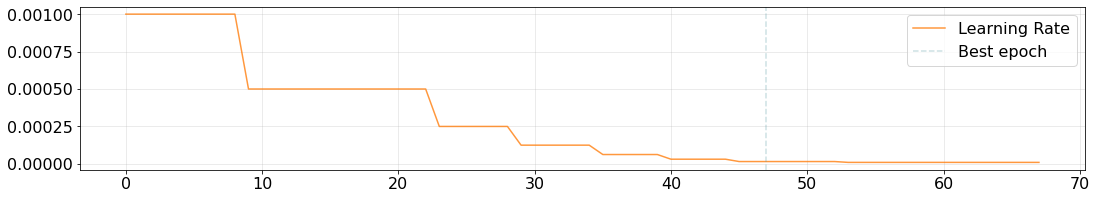

In [68]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('new_df/BiLSTM/ndf_att_roll__batch32_no_norm')
# model = tfk.models.load_model('BiLSTM')

In [69]:
# Predict the test set with the BiLSTM
predictions = model.predict(X_test)
predictions.shape

12/12 [==============================] - 1s 23ms/step


(365, 12)

Accuracy: 0.5205
Precision: 0.5262
Recall: 0.3503
F1: 0.3733


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


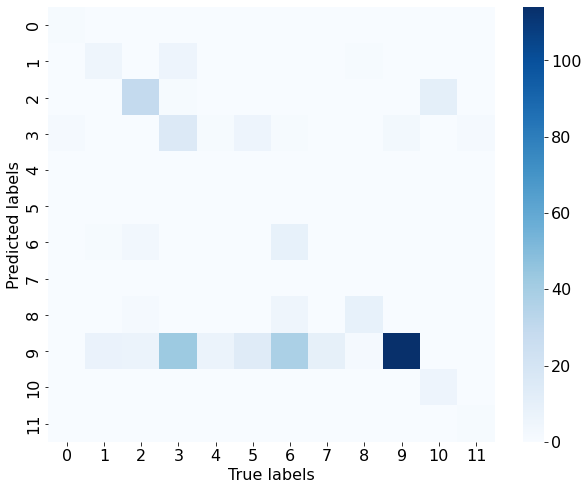

In [70]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]), yticklabels=list([0,1,2,3,4,5,6,7,8,9,10,11]))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()